In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
from PIL import Image
from pds.pds import PDS, PDSConfig, tensor_to_pil, pil_to_tensor
from pds.utils.imageutil import merge_images
from pds.utils.sysutil import clean_gpu
import torch.nn.functional as F
from tqdm import tqdm
from diffusers import DiffusionPipeline, DDIMScheduler, DDPMScheduler
from torch.optim.lr_scheduler import LambdaLR
import math
import random

from ipywidgets import interact, IntSlider, Output
from IPython.display import display, clear_output
import os

def get_cosine_schedule_with_warmup(
    optimizer, num_warmup_steps, num_training_steps, num_cycles: float = 0.5
):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(
            max(1, num_training_steps - num_warmup_steps)
        )
        return max(
            0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))
        )

    return LambdaLR(optimizer, lr_lambda, -1)


def seed_everything(seed=2024):
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 1. Load a PDS module.

In [3]:
device = "cuda"
sd_path = "./data/dreambooth_ckpt/person" # CHANGE THE PATH
src_prompt = "a photo of a sks man"
tgt_prompt = "a photo of a sks man raising his arms"
guidance_scale=50
pds_config = PDSConfig(
    sd_path,
    min_step_ratio=0.02,
    max_step_ratio=0.98,
    src_prompt=src_prompt,
    tgt_prompt=tgt_prompt,
    guidance_scale=guidance_scale,
)
pds_module = PDS(pds_config)

# 2. Prepare the latent of an input image.

In [4]:
img_path = "./data/images/person/images/frame_00001.png" # CHANGE THE PATH
src_img = Image.open(img_path)
src_img_tensor = pil_to_tensor(src_img).to(device)
h, w = src_img_tensor.shape[-2], src_img_tensor.shape[-1]

# resize the image such that the shortest side is 512
l = min(h, w)
new_h, new_w = int(512 / l * h), int(512 / l * w)
src_img_tensor = F.interpolate(src_img_tensor, (new_h, new_w), mode="bilinear")

with torch.no_grad():
    src_x0 = pds_module.encode_image(src_img_tensor)

# 3. PDS optimization stage.

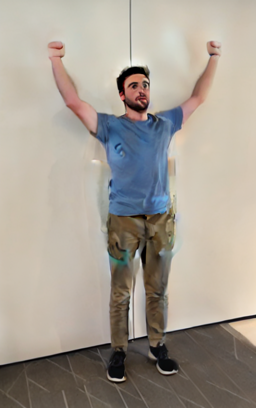

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:56<00:00,  2.11it/s]


interactive(children=(IntSlider(value=1, description='index', max=49), Output()), _dom_classes=('widget-intera…

Output()

In [5]:
seed_everything(63)

lr=1e-1
num_iters=500

clean_gpu()
tgt_x0 = src_x0.clone().requires_grad_(True)
optimizer = torch.optim.AdamW([tgt_x0], lr=lr)
# lr_scheduler = get_cosine_schedule_with_warmup (optimizer, 100, int(num_iters * 1.5))

pbar = tqdm(range(num_iters))
images = []
try:
    for i in pbar:
        optimizer.zero_grad()
        dic = pds_module(
            tgt_prompt=tgt_prompt,
            tgt_x0=tgt_x0, 
            src_x0=src_x0, 
            return_dict=True,
            method="pds", # You can also use either sds or dds.
            
        )
        grad = dic['grad'].cpu()
        loss = dic['loss']

        loss.backward()
        optimizer.step()
        # lr_scheduler.step()

        if i % 10 == 0:
            with torch.no_grad():
                tgt_img = pds_module.decode_latent(tgt_x0)
                tgt_img = tensor_to_pil(tgt_img)
                w, h = tgt_img.size
                l = min(w, h)
                new_w, new_h = int(w * 256 / l), int(h * 256 / l)
                tgt_img = tgt_img.resize((new_w, new_h))
                clear_output(wait=True)
                display(tgt_img)
                images.append(tgt_img)
except KeyboardInterrupt:
    pass
finally:
    slider = IntSlider(min=0, max=len(images)-1, step=1, value=1)
    output = Output()

    def display_image(index):
        with output:
            output.clear_output(wait=True)
            display(images[index])

    # Link the slider to the display function
    interact(display_image, index=slider)

    # Display the widgets
    # display(slider)
    display(output)

# 4. Refinement stage.

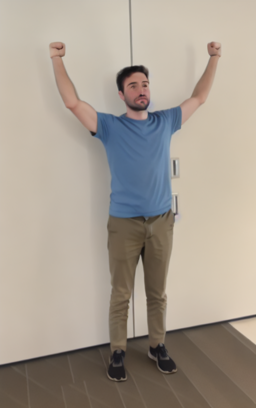

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.45it/s]


interactive(children=(IntSlider(value=1, description='index', max=4), Output()), _dom_classes=('widget-interac…

Output()

In [6]:
refinement_num_iters = 50
num_inference_steps = 20
guidance_scale=15
skip_min_ratio = 0.8
skip_max_ratio = 0.9

pds_module.config.guidance_scale=guidance_scale

pbar = tqdm(range(refinement_num_iters))
optimizer = torch.optim.AdamW([tgt_x0], lr=lr)
        
loss_func = torch.nn.MSELoss()

refined_images = []
try:
    for step in pbar:
        optimizer.zero_grad()
        min_step = int(num_inference_steps * skip_min_ratio)
        max_step = int(num_inference_steps * skip_max_ratio)
        skip = random.randint(min_step, max_step)
        with torch.no_grad():
            edit_x = pds_module.run_sdedit(
                tgt_x0, skip=skip, 
                tgt_prompt=tgt_prompt,
                num_inference_steps=num_inference_steps)
        loss = loss_func(edit_x, tgt_x0)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            if step % 10 ==0:
                tgt_img = pds_module.decode_latent(tgt_x0)
                tgt_img = tensor_to_pil(tgt_img)
                l = min(w, h)
                new_w, new_h = int(w * 256 / l), int(h * 256 / l)
                tgt_img = tgt_img.resize((new_w, new_h))
                clear_output(wait=True)
                display(tgt_img)
                refined_images.append(tgt_img)
except KeyboardInterrupt:
    pass
finally:
    slider = IntSlider(min=0, max=len(refined_images)-1, step=1, value=1)
    output = Output()

    def display_image2(index):
        with output:
            output.clear_output(wait=True)
            display(refined_images[index])

    # Link the slider to the display function
    interact(display_image2, index=slider)

    # Display the widgets
    # display(slider)
    display(output)
